In [12]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


In [13]:
def balance_classes(df, column_name):
    """Balance the classes of a binary column in a dataframe."""
    counts = df[column_name].value_counts()
    # Check if classes are already balanced
    if counts.min() == counts.max():
        return df
    # Identify majority and minority classes
    majority_class = counts.idxmax()
    minority_class = counts.idxmin()
    # Randomly select instances from majority class to remove
    majority_indices = df[df[column_name] == majority_class].index
    num_instances_to_remove = len(majority_indices) - counts[minority_class]
    indices_to_remove = np.random.choice(majority_indices, size=num_instances_to_remove, replace=False)
    # Remove instances from majority class
    df = df.drop(indices_to_remove)
    return df.reset_index(drop=True)

df = pd.read_csv('data/addresses_and_tweets.csv')
df = df.drop_duplicates(subset='text').reset_index(drop=True)
df = balance_classes(df, 'is_address').sample(4000)

In [14]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=42) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 3200
Test Data size 800


In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 7476


In [16]:
labels = train_data.is_address.unique().tolist()


In [17]:
from sklearn.preprocessing import LabelEncoder

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:", x_train.shape)
print("Testing X Shape:",  x_test.shape)


encoder = LabelEncoder()
encoder.fit(train_data.is_address.to_list())

y_train = encoder.transform(train_data.is_address.to_list())
y_test = encoder.transform(test_data.is_address.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)

Training X Shape: (3200, 30)
Testing X Shape: (800, 30)
y_train shape: (3200, 1)
y_test shape : (800, 1)


# Using Bert Model

In [19]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 30
LR = 0.001

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode the input data using BERT tokenizer
train_encodings = tokenizer(train_data.text.tolist(), truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH)
test_encodings = tokenizer(test_data.text.tolist(), truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH)

x_train = train_encodings['input_ids']
x_test = test_encodings['input_ids']

# Convert the input data to numpy arrays
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH, dtype='long', truncating='post', padding='post')
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH, dtype='long', truncating='post', padding='post')

# Define the BERT model architecture
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
bert_output = bert_model(sequence_input)[0]  # Extract the last hidden state from BERT
x = tf.keras.layers.GlobalAveragePooling1D()(bert_output)  # Pooling over the time dimension
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(factor=0.1, min_lr=0.01, monitor='val_loss', verbose=1)


2023-05-27 19:18:22.818681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-27 19:18:22.832417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-27 19:18:22.832614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [23]:
# Train the model
history = model.fit(x_train, y_train, batch_size=30, epochs=15, validation_data=(x_test, y_test), callbacks=[reduce_lr])

Epoch 1/15
107/107 [==============================] - 15s 136ms/step - loss: 0.6930 - accuracy: 0.5094 - val_loss: 0.6942 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 2/15
107/107 [==============================] - 14s 133ms/step - loss: 0.6930 - accuracy: 0.5094 - val_loss: 0.6941 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 3/15
107/107 [==============================] - 14s 130ms/step - loss: 0.6930 - accuracy: 0.5094 - val_loss: 0.6942 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 4/15
107/107 [==============================] - 14s 129ms/step - loss: 0.6930 - accuracy: 0.5094 - val_loss: 0.6941 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 5/15
107/107 [==============================] - 14s 130ms/step - loss: 0.6930 - accuracy: 0.5094 - val_loss: 0.6941 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 6/15
107/107 [==============================] - 14s 132ms/step - loss: 0.6930 - accuracy: 0.5094 - val_loss: 0.6942 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 7/15
107/107 [==============================] 

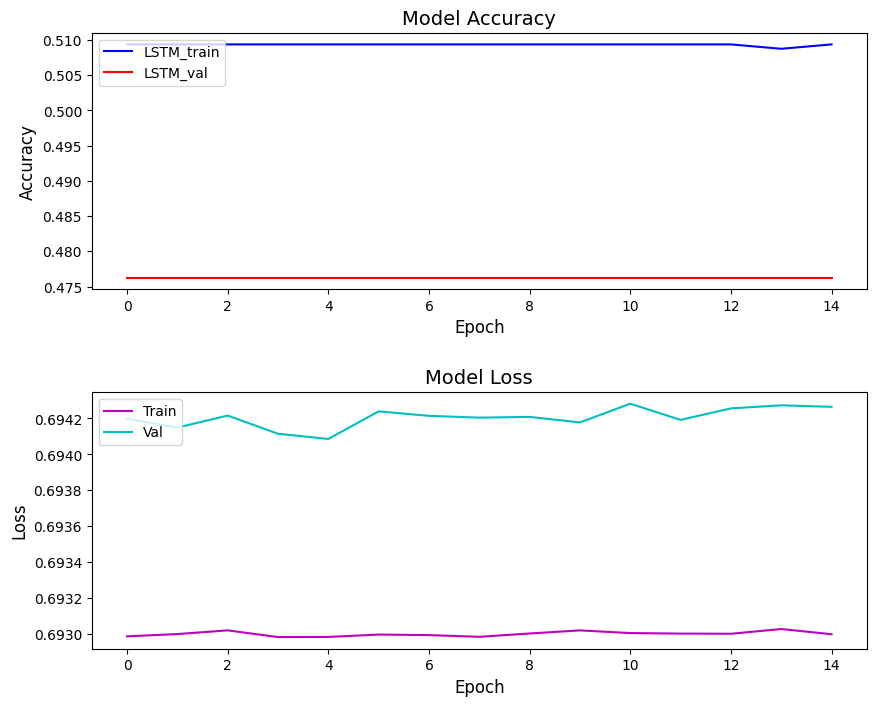

In [26]:
import matplotlib.pyplot as plt

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plot accuracy
ax1.plot(history.history['accuracy'], c='b')
ax1.plot(history.history['val_accuracy'], c='r')
ax1.set_title('Model Accuracy', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

# Plot loss
ax2.plot(history.history['loss'], c='m')
ax2.plot(history.history['val_loss'], c='c')
ax2.set_title('Model Loss', fontsize=14)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.legend(['Train', 'Val'], loc='upper left')

# Adjust vertical spacing between subplots
fig.subplots_adjust(hspace=0.4)  # Increase the value to add more vertical margin

# Increase the image size
fig.set_size_inches(10, 8)  # Adjust the width and height as desired

# Show the plot
plt.show()